In [3]:
import pandas
import pylab
import numpy
from pandas import *
from pylab import *

import sklearn
import random
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from __future__ import division
import math
import matplotlib.cm as cm
import matplotlib.pyplot as pyplot

###Need to replace the file path directory to use the read_csv###

#read the file "gamedata" and take a look at the first 5 items to make sure everything is in working order

#metacriticReviews.csv is data I captured from building a scraper and crawling through the following pages
#http://www.metacritic.com/browse/games/score/metascore/all/all/filtered?sort=desc


#Each instance in the dataframe is one video game. Each video game contains the following attributes:
#title (name of the game) 
#release (day the game was published for sale in North America)
#platform (the console that the video game release on. **Note: Games may appear multiple times due to multiple console-release. Often game release on different consoles have slightly different experiences.
#rating (the ESRB rating of the game. Rates games based on appropriate consumer audience)
#publisher (company that published the game)
#genre (genre(s) pertaining to the game.)
#metascore (aggregate media and critic score of the game. Aggregate based on numerous media outlets and publications)
#userscore (aggregate metacritic community score of the game. Metacritic users may award any game a score, which is the added to the average that makes up the userscore)

###Eventually, the goal here is to try and come up with a model that will predict what the metascore of new games will be in the future
###Because I'm trying to predict the future metascore of these games, I believe the most appropriate tool would be to look at a regression model


gameReviews = read_csv("/Users/JuupoMac/Desktop/gamedata/metacritic.csv")
gameReviews.head()



,﻿title,release,platform,rating,publisher,genres,metascore,userscore,pagination,pagination-href
0,DiRT 2,"Sep 8, 2009",DS,E,Codemasters,"Simulation, ...",73,tbd,61.0,http://www.metacritic.com/browse/games/score/m...
1,Magnetica,"Jun 5, 2006",DS,E,Nintendo,"Miscellaneous, ...",68,8.1,82.0,http://www.metacritic.com/browse/games/score/m...
2,Pro Evolution Soccer 2009,"Nov 11, 2008",X360,E,Konami,"Sports, ...",74,6.8,58.0,http://www.metacritic.com/browse/games/score/m...
3,Remember Me,"Jun 4, 2013",X360,M,Capcom,null,70,7.5,74.0,http://www.metacritic.com/browse/games/score/m...
4,Oddworld: Munch's Oddysee,"Nov 6, 2001",XBOX,T,Microsoft Game Studios,"Action, ...",80,8.6,32.0,http://www.metacritic.com/browse/games/score/m...


In [4]:
#Descriptive statistics of metascore 
gameReviews['metascore'].describe()

count    13250.000000
mean        69.861887
std         12.992643
min         11.000000
25%         62.000000
50%         72.000000
75%         79.000000
max         99.000000
Name: metascore, dtype: float64

In [5]:
#Some general data clean up
#Dropping the pagination and pagination-href columns, they will be of no use to this project
gameReviews.drop(['pagination', 'pagination-href'], axis = 1, inplace=True)

In [6]:
#dropping title in favor of setting it as an index
colName =gameReviews.columns[0]
gameReviews=gameReviews.rename(columns = {colName:'title'})
gameReviews.set_index(gameReviews.title)
gameReviews = gameReviews.drop('title', 1)

In [7]:
gameReviews.head()

,release,platform,rating,publisher,genres,metascore,userscore
0,"Sep 8, 2009",DS,E,Codemasters,"Simulation, ...",73,tbd
1,"Jun 5, 2006",DS,E,Nintendo,"Miscellaneous, ...",68,8.1
2,"Nov 11, 2008",X360,E,Konami,"Sports, ...",74,6.8
3,"Jun 4, 2013",X360,M,Capcom,null,70,7.5
4,"Nov 6, 2001",XBOX,T,Microsoft Game Studios,"Action, ...",80,8.6


In [8]:
#For date, I'd like to keep things simple for this project and convert it to the pandas date time object
#This will make it easier to explore the the release date of these games in graphs, histograms, heatmaps, etc.
gameReviews['release'] =  pandas.to_datetime(gameReviews['release'])


In [9]:
gameReviews.head()

,release,platform,rating,publisher,genres,metascore,userscore
0,2009-09-08,DS,E,Codemasters,"Simulation, ...",73,tbd
1,2006-06-05,DS,E,Nintendo,"Miscellaneous, ...",68,8.1
2,2008-11-11,X360,E,Konami,"Sports, ...",74,6.8
3,2013-06-04,X360,M,Capcom,null,70,7.5
4,2001-11-06,XBOX,T,Microsoft Game Studios,"Action, ...",80,8.6


In [10]:
#Preparing to replace TBD values of userscore with an imputed value. Need to replace all instances of 'tbd' in userscore with '0.0'
#After replacing, I can recast all of the values as floats and impute new values into the userscore
#Need to cover two cases: tbd (no pending reviews) and null (missing data for whatever reason)

gameReviews['userscore'] = gameReviews['userscore'].str.replace('tbd', '0.0')
gameReviews['userscore'] = gameReviews['userscore'].str.replace('null', '0.0')

In [11]:
#Testing the replace
gameReviews.head()

,release,platform,rating,publisher,genres,metascore,userscore
0,2009-09-08,DS,E,Codemasters,"Simulation, ...",73,0.0
1,2006-06-05,DS,E,Nintendo,"Miscellaneous, ...",68,8.1
2,2008-11-11,X360,E,Konami,"Sports, ...",74,6.8
3,2013-06-04,X360,M,Capcom,null,70,7.5
4,2001-11-06,XBOX,T,Microsoft Game Studios,"Action, ...",80,8.6


In [12]:
#For KNN imputation of userscores
#from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute

#cast all userscore values to float
gameReviews.userscore = gameReviews.userscore.astype(float)

#After taking a quick look through the data I've noticed that there are plenty of instances with missing data
#Here I am going to try out a technique to impute the missing data based on a median of userscores
#I'm aware that there are 'better' ways of completing this, but for now, I think a median of userscores will work for this project
#I'd like to come back to this section soon and try either a KNN imputation or something more complex

#Now that all of the data in userscores is a float, I should be able to find the most frequent value for userscore with the following:
#Going to create a manual imputation without importing any more modules
#KNN(k=3).complete(gameReviews.userscore)
mostFreqScore = gameReviews['userscore'].median()
gameReviews.userscore.replace(0.0, mostFreqScore, inplace=True)

In [13]:
#Casting the metascore attributes to floats
gameReviews.metascore = gameReviews.metascore.astype(float)

#converting all userscores to a 100 point scale system. Currently, the user scores are on a 10point scale. This will be useful in graphing
gameReviews.userscore = gameReviews.userscore.multiply(10)

In [14]:
gameReviews.head()

,release,platform,rating,publisher,genres,metascore,userscore
0,2009-09-08,DS,E,Codemasters,"Simulation, ...",73.0,73.0
1,2006-06-05,DS,E,Nintendo,"Miscellaneous, ...",68.0,81.0
2,2008-11-11,X360,E,Konami,"Sports, ...",74.0,68.0
3,2013-06-04,X360,M,Capcom,null,70.0,75.0
4,2001-11-06,XBOX,T,Microsoft Game Studios,"Action, ...",80.0,86.0


//anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


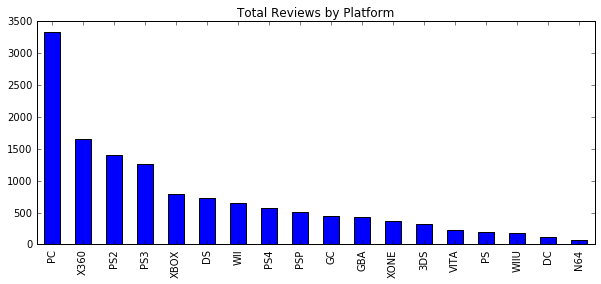

In [15]:
%matplotlib inline

#Going to display a few visual representations of the data before looking at a problem I'd like to solve using this dataframe
#Which platform contains the most reviews?
figure, ax = pylab.subplots(1,1,figsize=(10,4))
gameReviews.platform.value_counts(normalize=False).plot(kind='bar',ax=ax);
ax.set_title("Total Reviews by Platform");
figure.show()

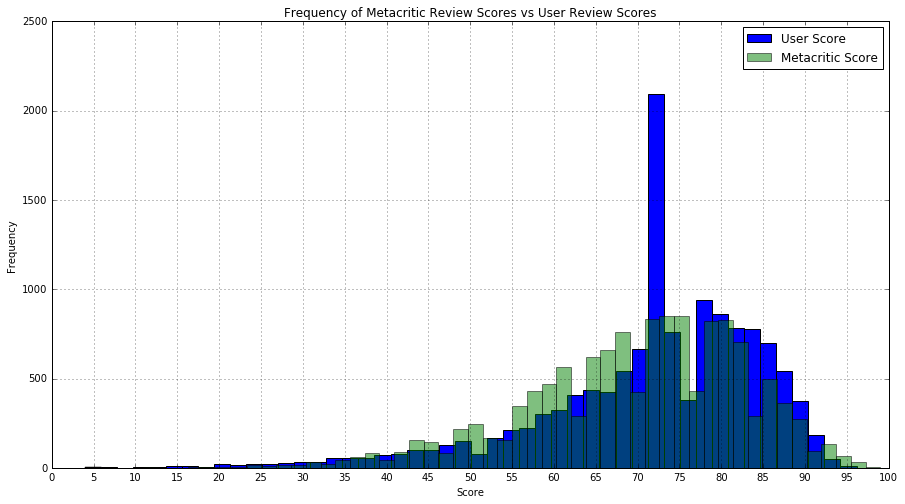

In [16]:
#For the next graph, I thought it would be interesting to look at a comparision between the userscore and the metascore
#I took inspiration for this from a forum-poster who looked at publication score and their community's scores on the same games
#Histogram to show the difference between IGN ratings and user ratings 



fig, ax = pylab.subplots(1,1,figsize=(15,8))
gameReviews.userscore.hist(ax=ax,bins=50,alpha=1.0,label="User Score")
ax.hist(gameReviews.metascore,bins=50,alpha=0.5,label="Metacritic Score");
ax.set_ylabel("Frequency")
ax.set_xlabel("Score")
ax.legend(loc='best')
ax.set_xticks(np.linspace(0,100,21))
ax.set_xlim(0,100)
ax.set_title("Frequency of Metacritic Review Scores vs User Review Scores");
#obviously the problem of using the median to fill in missing space is causing an obvious problem here. will run this again to test KNN imputation

In [17]:
#Before I run some KNN clustering code, I think it may be useful to create another attribute
#Namely, whether the game is a handheld game, or a console game. To do this, I will create a simple function

def gameType(data):
    if data.platform == 'DS': 
        return 'handheld'
    elif data.platform == 'PSP': 
        return 'handheld'
    elif data.platform == 'VITA': 
        return 'handheld'
    elif data.platform == '3DS': 
        return 'handheld'
    elif data.platform == 'GBA': 
        return 'handheld'
    else:
        return 'console'
    
gameReviews['gameType'] = gameReviews.apply(gameType, axis=1)


In [18]:
#Keep genre simple and limit each game to its most appropriate genre
gameReviews['genres'] = gameReviews['genres'].apply(lambda x: x.split(',')[0])

In [19]:
#Now that I've created an attribute for game type, clustering may be more insightful
#I expect clustering to be based on platform or even genre. 
#I'm exploring the difference between clustering with only numeric values, and clustering with categorical values

#Replace null in game ratings
gameRatingList = ['AO',
                  'E', 
                  'E10+', 
                  'K-A', 
                  'M', 
                  'RP', 
                  'T']
#gameReviews['rating'] = gameReviews['rating'].str.replace('null', random.random.choice(gameRatingList))
gameReviews.loc[gameReviews['rating'] == 'null','rating'] = gameReviews['rating'].apply(lambda x: random.choice(gameRatingList))

#Replace null in game genres
gameGenresList = ['Action',
 'Action Adventure',
 'Adventure',
 'Driving',
 'First-Person',
 'Miscellaneous',
 'Role-Playing',
 'Simulation',
 'Sports',
 'Strategy']
#gameReviews['genres'] = gameReviews['genres'].str.replace('null', random.choice(gameGenresList))
gameReviews.loc[gameReviews['genres'] == 'null','genres'] = gameReviews['genres'].apply(lambda x: random.choice(gameGenresList))


#Drop publishers, converting it to numeric data is just not practical as it causes 1305 attributes
gameReviews.drop(['publisher'], axis = 1, inplace=True)

##Preserving original data here
gameReviewsNumOnly = gameReviews

gameReviewsNumOnly = pandas.get_dummies(gameReviewsNumOnly, columns = ['platform', 'rating','genres', 'gameType'])


In [20]:
gameReviews.genres.value_counts()
#Testing to see if it removed null properly

Action              3846
Action Adventure    1501
Sports              1470
Role-Playing        1217
Miscellaneous       1200
Strategy            1193
Driving             1039
Simulation           776
Adventure            589
First-Person         419
Name: genres, dtype: int64

In [21]:
gameReviews.rating.value_counts()
#Testing to see if it removed null properly

T       4282
E       4132
M       2615
E10+    1792
K-A      154
RP       142
AO       133
Name: rating, dtype: int64

In [22]:
###Preprocessing work is done, now I'm going to call some functions to run some analysis


##Making a few methods for vector arithmetic to propely calculate means, scalar multiplication, etc.
##Will be called by the Kmeans clustering algorithm below
    
#Simple componentwise vector addition. Only allowed to add vectors of the same size
#(v[0] + w[0]) + (v[1] + w[1]) + ..... (v[k] + w(k)) where v and w are vectors
def vectorAdd(v, w):
    return [v_i + w_i for v_i, w_i in zip(v,w)]

#Componentwise vector subtraction
def vectorSubtract(v,w):
    return [v_i - w_i for v_i, w_i in zip(v,w)]
    
#Componentwise summation of all vectors (in this case - in a given cluster)
#Simply adding one at a time. In code this can be handled fairly easily - a simple reduce
def vectorSum(vectors):
    result = vectors[0]
    for vector in vectors[1:]:
        result = vectorAdd(result, vector)
    return result
    #return reduce(vectorAdd, vectors)
    
#Scalar multiplication
def scalarMultiply(c, v):
    return [c * v_i for v_i in v]

#Dot product function
def dotProd(v,w):
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

#Sum of squares function
def sumOfSquares(v):
    return dotProd(v, v)

#Squared Distance function
def squaredDistance(v, w):
    return sumOfSquares(vectorSubtract(v, w))
    
#And finally, a vector mean method
#will be used to find the componentwise mean of a list of all same-sized vectors
def vectorMean(vectors):
    n = len(vectors)
    return scalarMultiply(1/n, vectorSum(vectors))


In [23]:
#Building a very simple Kmeans clustering algorithm:
class kMeans:
    
    def __init__(self, k):
        self.k = k
        self.means = None
        
    def classify(self, input):
        #Move the index of the cluster closest to the input
        return min(range(self.k), key = lambda i: squaredDistance(input, self.means[i]))

    def train(self, inputs):
        #self.means = inputs.sample(self.k)
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            newAssignments = map(self.classify, inputs)
        
            #if no assignments have changed; done
            if assignments == newAssignments:
                return
        
            #Otherwise, keep new assignments
            assignments = newAssignments
        
            #compute new means based on new assignments
            for i in range(self.k):
                #find all the points assigned to cluster i
                iPoints = [p for p, a in zip(inputs, assignments) if a == i]
            
                #make sure iPoints is not empty 
                if iPoints:
                    self.means[i] = vectorMean(iPoints)

In [24]:
#create an instance of the cluster and train it to train inputs   
#Testing a randomly generated dataframe
#df = pandas.DataFrame(numpy.random.randint(0,100,size=(100, 2)), columns=list('AB'))

inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(0)
cluster = kMeans(3)
cluster.train(inputs)
print cluster.means

[[-43.800000000000004, 5.4], [-15.888888888888888, -10.333333333333332], [18.333333333333332, 19.833333333333332]]


In [25]:
gameReviewsNumOnly.release = gameReviewsNumOnly['release'].apply(lambda x: x.toordinal())


In [30]:
gameReviewsNumOnly['release'] = gameReviewsNumOnly['release'].astype(int)


In [44]:
gameReviewsNumOnly.apply(lambda x: pandas.to_numeric(x, errors='ignore'))


,release,metascore,userscore,platform_3DS,platform_DC,platform_DS,platform_GBA,platform_GC,platform_N64,platform_PC,...,genres_Adventure,genres_Driving,genres_First-Person,genres_Miscellaneous,genres_Role-Playing,genres_Simulation,genres_Sports,genres_Strategy,gameType_console,gameType_handheld
0,733658,73,73,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,732467,68,81,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,733357,74,68,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,735023,70,75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,730795,80,86,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,735448,68,88,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
6,733373,74,83,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7,732245,61,74,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,736010,64,68,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
9,733524,59,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


For n clusters =  2 The average silhouette score is:  0.602077727776


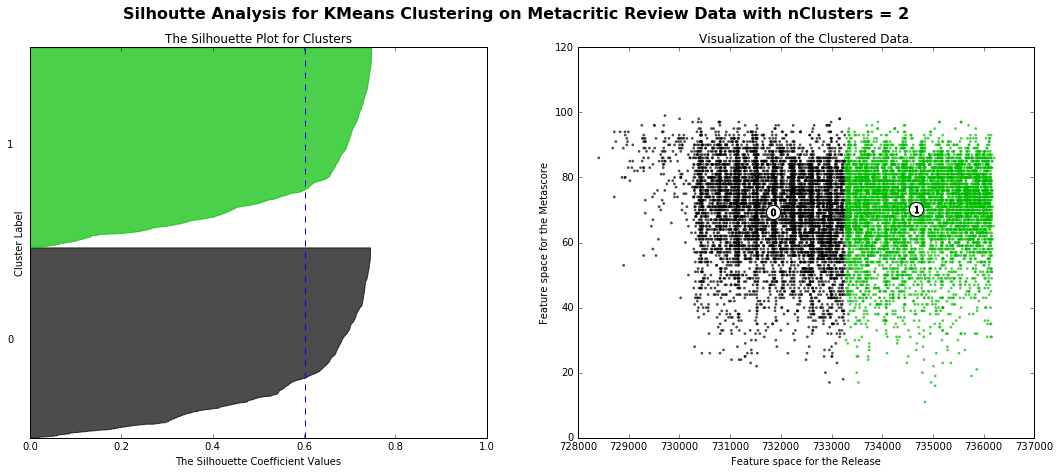

For n clusters =  3 The average silhouette score is:  0.578910693099


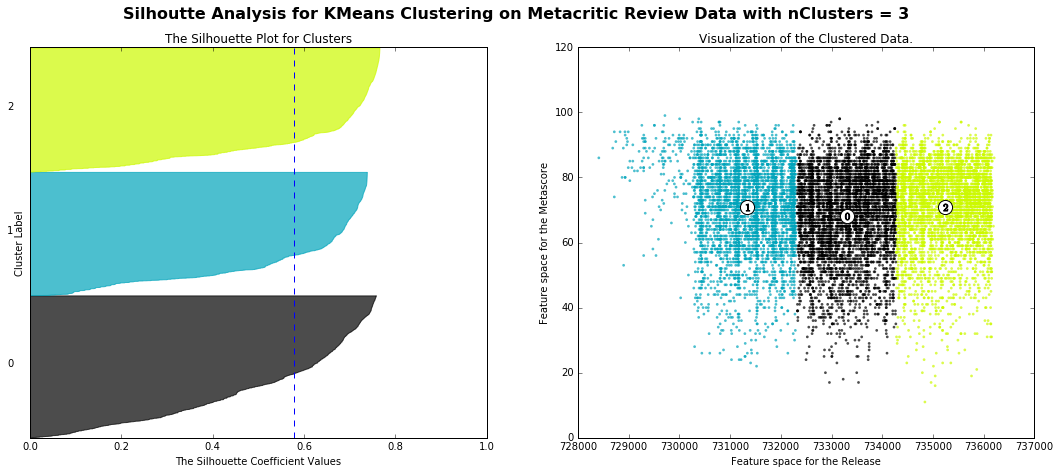

For n clusters =  4 The average silhouette score is:  0.567010979011


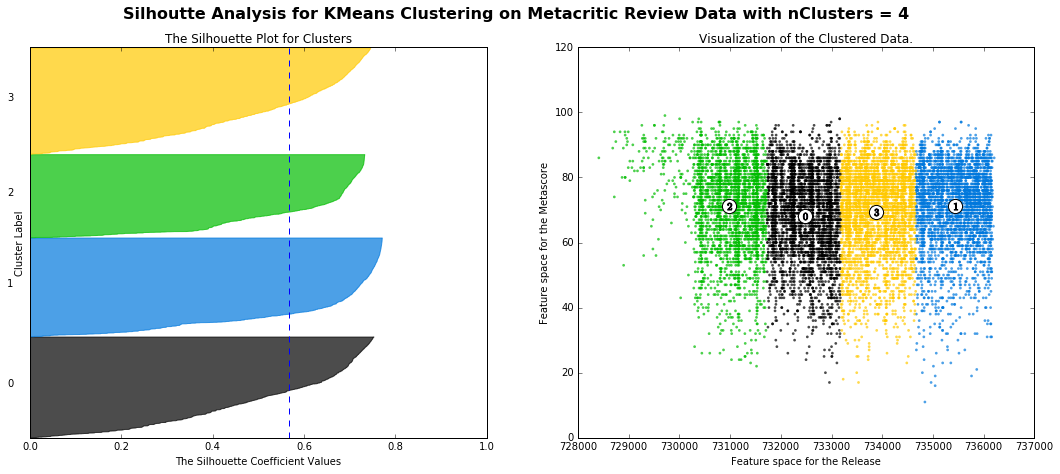

For n clusters =  5 The average silhouette score is:  0.551825032274


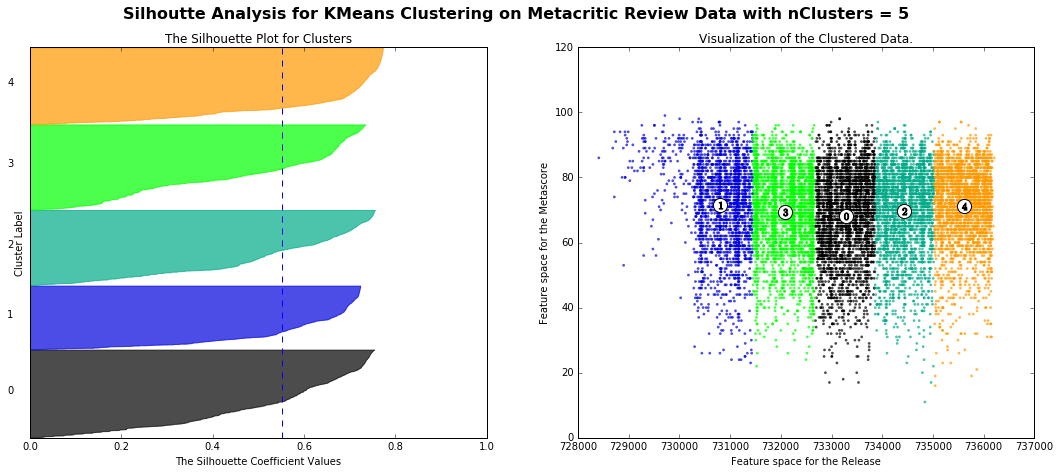

For n clusters =  6 The average silhouette score is:  0.541570139184


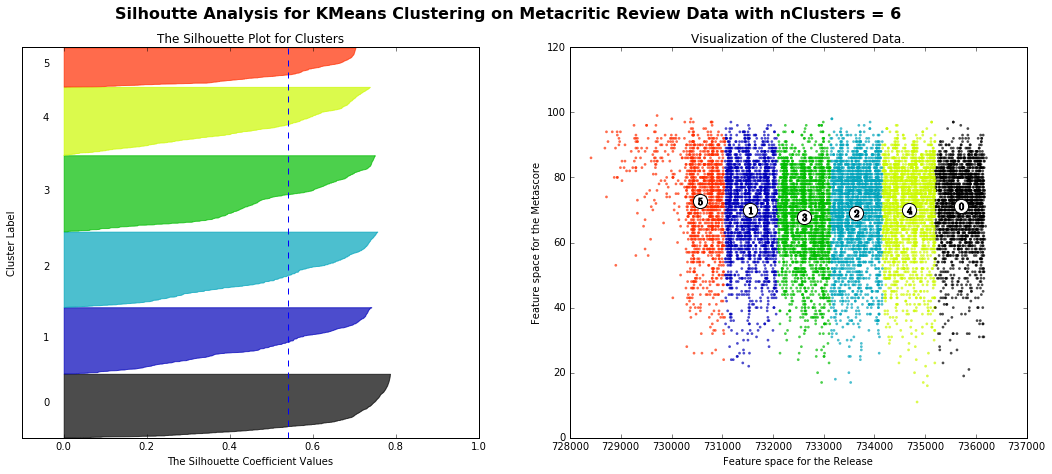

For n clusters =  7 The average silhouette score is:  0.539124900439


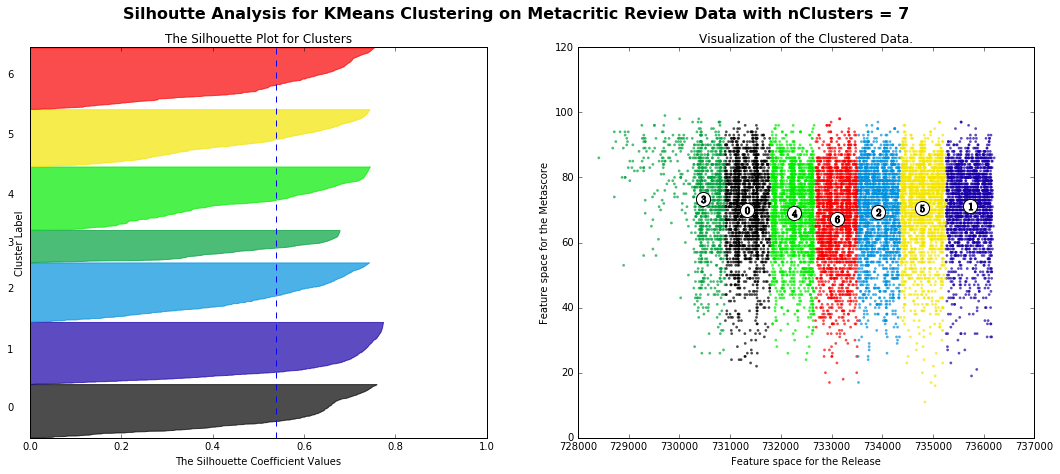

For n clusters =  8 The average silhouette score is:  0.544956165792


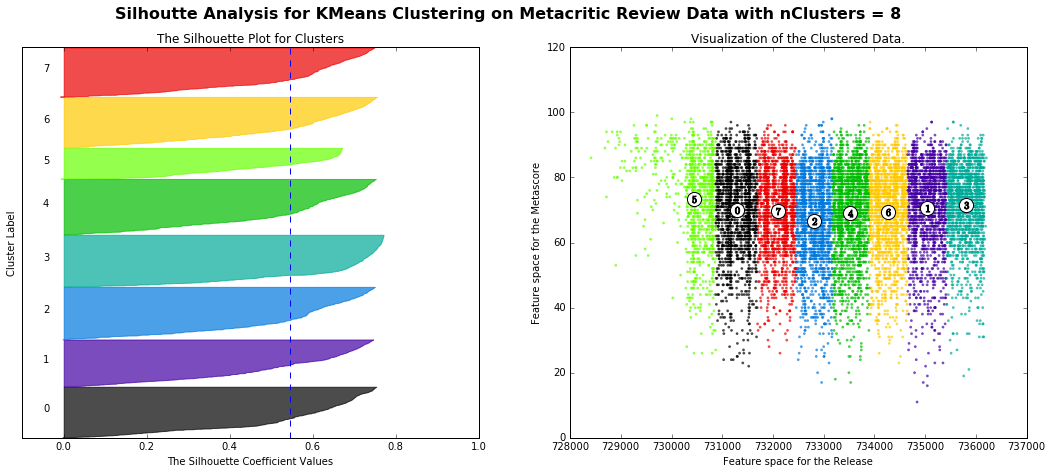

In [64]:
#Now perform some actual clustering on the metacritic reviews data
#going to use sklearn's silhouette analysis to find the right number of clusters and then visualize the results

nClusters = [2,3,4,5,6,7,8]
 
#going to build a few subplots to show each cluster size/plot and the silhouette score/plot of each cluster size
#Draws subplots, 2 plots per nCluster value and then fits the kMeans clustering algorithm to the data
#Computers the silhouette values for cluster n and then finds the silhouette average
#Helps determine the correct n cluster

for n in nClusters:
    #ax1 is the silhouette subplot
    #ax2 is the cluster subplot
    figure, (ax1, ax2) = pyplot.subplots(1,2)
    figure.set_size_inches(18,7)
    
    #providing some blank space between plots
    ax1.set_ylim([0, len(gameReviewsNumOnly) + (n+1) *10])
    
    #here the kMeans cluster is initialized with nClusters
    cluster = KMeans(n_clusters = n)
    cluster.fit(gameReviewsNumOnly)
    clusterLabels = cluster.predict(gameReviewsNumOnly)
    
    #compute the silhouette scores for each sample
    silhouetteVals = silhouette_samples(gameReviewsNumOnly, clusterLabels)
    
    #silhouette score for all samples
    silhouetteAvg = silhouette_score(gameReviewsNumOnly, clusterLabels)
    print 'For n clusters = ', n , 'The average silhouette score is: ' , silhouetteAvg
    
    
    #For loop that calculates the cluster values and labels and then fills the graph for nClusers = i
    yLow = 10
    for i in range(n):
        #Collect silhouette scores for each sample and sort them
        clusterSilhouetteVals = silhouetteVals[clusterLabels == i]
        clusterSilhouetteVals.sort()
        
        clusterSize = clusterSilhouetteVals.shape[0]
        yHigh = yLow + clusterSize
        
        color = cm.spectral(float(i)/n)
        ax1.fill_betweenx(numpy.arange(yLow, yHigh), 0, clusterSilhouetteVals, facecolor = color, edgecolor = color, alpha = .7)
        
        #label silhouette plots with cluster numbers in the center
        ax1.text(-0.05, yLow + .5 * clusterSize, str(i))
        
        #compute new yLow for the next plot
        yLow = yHigh + 10 
        
    ax1.set_title("The Silhouette Plot for Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
        
    #draw a vertical line that represents the average silhouette score for n clusters
    ax1.axvline(x = silhouetteAvg, color = "blue", linestyle = "--")
        
    #Labeling axis
    ax1.set_yticks([])
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        
    #Cluster Results Plot
    colors = cm.spectral(clusterLabels.astype(float)/n)
    ax2.scatter(gameReviewsNumOnly.release, gameReviewsNumOnly.metascore, marker = '.', s = 30, lw = 0, alpha = .7, c = colors)
        
    #label the clusters
    centers = cluster.cluster_centers_
    #draw circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:,1], marker = 'o', c = "white", alpha = 1, s = 200)
    
    #Mark the scatter plot with the centers of the clusters
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, s = 50)
            
    #Finishing touches on the labels of the graph    
    ax2.set_title("Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature space for Release")
    ax2.set_ylabel("Feature space for Metascore")
        
    pyplot.suptitle(("Silhoutte Analysis for KMeans Clustering on Metacritic Review Data with nClusters = %d" %n), fontsize = 16, fontweight = 'bold')
    pyplot.show()

In [77]:
#I'd like to perform a simple regression to try and predict the metascore of a game
#Build the model with the training data I have and then take games with an unknown metascore in the future and try to predict that scor
from sklearn.linear_model import LinearRegression

#drop metascore
metascoreArray = gameReviewsNumOnly.metascore

In [75]:
metascoreArray

0        73
1        68
2        74
3        70
4        80
5        68
6        74
7        61
8        64
9        59
10       64
11       67
12       70
13       77
14       64
15       71
16       72
17       75
18       75
19       63
20       77
21       63
22       79
23       46
24       72
25       39
26       79
27       70
28       79
29       76
         ..
13220    76
13221    69
13222    84
13223    59
13224    34
13225    56
13226    65
13227    69
13228    83
13229    77
13230    85
13231    56
13232    93
13233    33
13234    54
13235    69
13236    78
13237    79
13238    50
13239    78
13240    84
13241    70
13242    60
13243    84
13244    67
13245    77
13246    80
13247    85
13248    66
13249    56
Name: metascore, dtype: int64

In [78]:
regress = LinearRegression()

In [81]:
#drop metascore
gameReviewsRegReady = gameReviewsNumOnly.drop('metascore', axis =1)

In [83]:
regress.fit(gameReviewsRegReady, metascoreArray)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [84]:
print "Estimated Intercept Coefficient: " , regress.intercept_

Estimated Intercept Coefficient:  -557.278069945


In [86]:
print "Number of Coefficients: " , len(regress.coef_)

 Number of Coefficients:  39


In [91]:
coefficientFeatures = pandas.DataFrame(zip(gameReviewsRegReady.columns, regress.coef_), columns = ["features", "coefficients"])

In [92]:
coefficientFeatures

,features,coefficients
0,release,0.000797
1,userscore,0.582049
2,platform_3DS,-0.155460
3,platform_DC,1.670142
4,platform_DS,-1.785412
5,platform_GBA,-0.787626
6,platform_GC,-0.873192
7,platform_N64,4.911426
8,platform_PC,1.054580
9,platform_PS,0.238820


In [93]:
#Interestingly, N64 and metascore has a high correlation with metascore. 
#This is probably because a lot of the "greatest games ever made" are considered to be on the N64 platform
#I was surpirsed at first, but the coefficient makes a lot of sense

#Now I'd like to split the data into a training and testing set randomly to try and predict the metascore
XTrain, XTest, YTrain, YTest = sklearn.cross_validation.train_test_split(gameReviewsRegReady, metascoreArray, test_size = .33, random_state =5) 

In [94]:
regress2 = LinearRegression()
regress2.fit(XTrain, YTrain)
predictTrain = regress2.predict(XTrain)
predictTest = regress2.predict(XTest)

In [99]:
#Mean Squared Error ends up being relatively close to for the training data and the test data
print "Fit a model XTrain, and calculate Mean Squared Error with YTrain: ", numpy.mean((YTrain - predictTrain) ** 2)
print "Fit a model XTrain, and calculate Mean Squared Error with XTest, YTest: " , numpy.mean((YTest - predictTest) ** 2)

Fit a model XTrain, and calculate Mean Squared Error with YTrain:  108.549315484
Fit a model XTrain, and calculate Mean Squared Error with XTest, YTest:  111.915907731


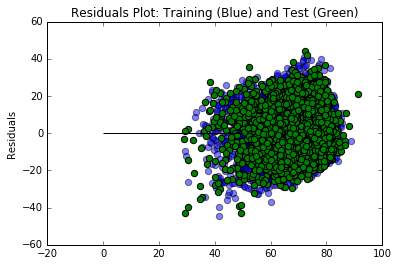

In [107]:
#Plotting the residuls to see if they are scattered around 0
pyplot.scatter(predictTrain, predictTrain - YTrain, c='blue', s=40, alpha = .5)
pyplot.scatter(predictTest, predictTest - YTest, c='green', s=40)
pyplot.hlines(y=0, xmin=0, xmax=50, color = "black", linestyle = 'solid')
pyplot.title("Residuals Plot: Training (Blue) and Test (Green)")
pyplot.ylabel("Residuals")